In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
large = screen_funds('Equities', 'Domestic', 'Large-Cap')
mid = screen_funds('Equities', 'Domestic', 'Mid-Cap')
small = screen_funds('Equities', 'Domestic', 'Small-Cap')
print(len(large), len(mid), len(small))
quote = Quote(large + mid + small, 64, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

80 20 21
from 2019-04-18 to 2019-07-19 - 121


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

89


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
MTUM,60,0.148961,0.334922,0.421069,9.196521,2.859384
USMV,60,0.122836,0.269379,0.426533,7.337667,2.180427
SPLV,60,0.116176,0.280218,0.386268,6.326355,2.660443
FPX,60,0.113120,0.385043,0.273174,7.260390,5.445800
PDP,60,0.111398,0.379590,0.272562,6.945935,3.974186
ADX,60,0.100692,0.328709,0.282181,6.586257,5.318352
VIG,60,0.084717,0.315109,0.243663,4.940476,4.634193
JKE,60,0.083095,0.391632,0.191911,5.026249,7.390317
IWP,60,0.075723,0.388974,0.174269,4.746636,6.491853


evicted FDL 0.855 0.705
evicted ADX 0.810 0.736
evicted XSLV 0.683 0.683
retry backlogs ['VTI', 'IWY', 'SPLG', 'DSI', 'SCHV', 'VOOG', 'VV', 'VONV', 'DLN', 'MGV', 'IWB', 'VONE', 'VONG', 'SCHX', 'VOO', 'SPY', 'VOE', 'IVW', 'FNDX', 'VO', 'SCHB', 'SPYG', 'RSP', 'MGC', 'OEF', 'IVV', 'QQQ', 'VUG', 'IVE', 'IWV', 'VTV', 'PRF', 'SPYV', 'ITOT', 'IJK', 'DGRO', 'VBK', 'IWR', 'SPLV', 'IUSV', 'JKE', 'VXF', 'GSLC', 'SDY', 'TILT', 'MDYG', 'PKW', 'QUAL', 'FEX', 'SCHG', 'SPTM', 'IWF', 'XMLV', 'SUSA', 'VYM', 'FPX', 'IWS', 'MOAT', 'MGK', 'IYY', 'VIG', 'LRGF', 'IWD', 'MTUM', 'FVD', 'PDP', 'IWP', 'JHMM', 'HDV', 'VOT', 'SPHQ', 'DGRW', 'SCHM', 'VB', 'NOBL', 'FTCS', 'ONEQ', 'FV', 'IWO', 'IUSG', 'RPG', 'DVY', 'DIA', 'PWV', 'USA'] at 0.905/-0.51 - 0.427
evicted IWO 0.832 0.661
evicted USA 0.858 0.775
retry backlogs ['MDYG', 'SCHB', 'VIG', 'VTI', 'VV', 'DLN', 'VONV', 'VONG', 'VOOG', 'IWY', 'SCHX', 'IWR', 'SDY', 'SCHV', 'OEF', 'VOO', 'SPY', 'SPYV', 'TILT', 'IWV', 'MGC', 'IVE', 'IVV', 'VO', 'VUG', 'VTV', 'SPYG', 'M

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,60.0,0.138026,0.303768,-0.408763,-0.035960,0.134187,0.307747,0.979139,0.428252,8.415803,2.377627
USMV,60.0,0.122836,0.269379,-0.355133,-0.044916,0.092972,0.266281,0.844584,0.426533,7.337667,2.180427
MTUM,60.0,0.148961,0.334922,-0.476787,-0.078731,0.143408,0.367320,1.172438,0.421069,9.196521,2.859384


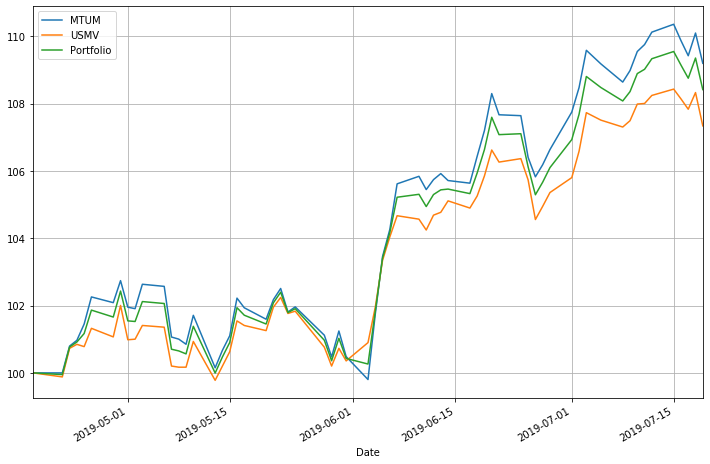

In [4]:
bounds = .12, .16
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=1, bounds=bounds)
quote.setup_mask(['MTUM', 'USMV'])
sd = quote.optimize_portfolio(_lambda=1, bounds=bounds)
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=1, bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)